In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from scipy.odr import *
from scipy.optimize import *
from IPython.display import display, Math, Latex

In [5]:
def plotData(X,Y,lims=((0,10),(0,10)),mStyle='.',lStyle='',col='r',aLbl=('x','y'), ttl='Test ODR'):
    (xlims,ylims) = lims
    xlbl,ylbl = aLbl
             
    p = plot(X,Y,marker=mStyle,ls=lStyle, c=col)
    title(ttl)
    xlabel(xlbl)
    ylabel(ylbl)
    xlim(xlims)
    ylim(ylims)
    return p

# Test ODR with a realistic non-linear curves

We want to create a set of data that can hopefully highlight how the ODR algorithm works for a more realistic non-linear model, like a simple $x^2$ function

### Define basic functions to test ODR

This test will use a simple $x^2$ equation to test the ODR model.  More specifically it will use the following equation to model any simple quadratic equation: $$ f(x)=\alpha (x+\beta)^2 + \gamma $$

In [126]:
def sq(beta, X):
    f = beta[0]*(X+beta[1])**2 + beta[2]
    return f
def sqSimple(beta, X):
    f = beta*(X)**2
    return f
def dsq(beta,X):
    df = 2*beta[0]*(X+beta[1])
    return df
def dsqSimple(beta,X):
    df = 2*beta*X
    return df
def bCalc(y, x, m):
    return y - m*x
def simpLine(x, m, b):
    return m*x + b

### Create data

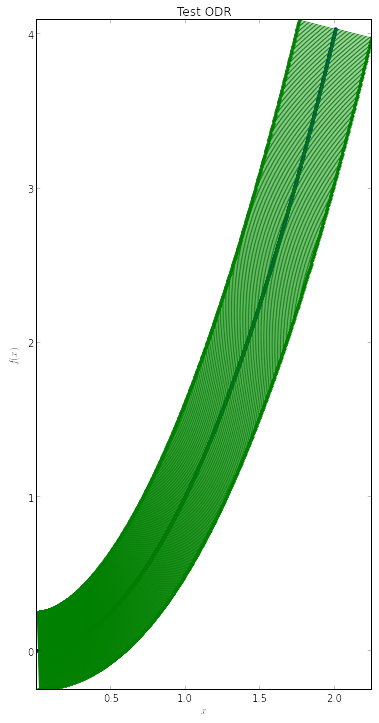

In [202]:
# Create fake data
MaxX = 2.01
Xs = arange(0.01,MaxX,0.001)

# Define pVals
alpha = 1.0
beta = 0.
gamma = 0.

Fs = sq((alpha, beta, gamma),Xs)
Ms = dsq((alpha, beta, gamma), Xs)

invMs = -(1/Ms)
Bs = bCalc(Fs, Xs, Ms)
invBs = bCalc(Fs, Xs, invMs)

# Setup data in order to plot a high-resolution theoretical curve
thXs = arange(0,MaxX,0.001)
thFs = sq((alpha, beta, gamma),thXs)

# Skew the data
scale = 0.25     # Set this variable to scale the vector length
dx = scale*cos(arctan(invMs))
dy = scale*sin(arctan(invMs))

skewXs = Xs.copy()
skewXs[0::2] -= dx[0::2]
skewXs[1::2] += dx[1::2]
skewFs = Fs.copy()
skewFs[0::2] -= dy[0::2]
skewFs[1::2] += dy[1::2]

# Plot the data
fig = figure(figsize(6,12))
plotData(Xs, Fs, lims=((0,max(Xs)),(0,max(Fs))), lStyle='', col='b', aLbl=(r'$x$',r'$f(x)$'))
for i, m in enumerate(Ms):
#    plotData(thXs, simpLine(thXs, m, Bs[i]), mStyle='', lStyle='-.')
#    plotData(thXs, simpLine(thXs, invMs[i], invBs[i]), mStyle='', lStyle='-.', col='g')
    plotData([Xs[i], skewXs[i]],[Fs[i],skewFs[i]], mStyle='', lStyle='-', col='g')
plotData(skewXs, skewFs, lims=((min(skewXs),max(skewXs)),(min(skewFs),max(skewFs))),col='g',aLbl=(r'$x$',r'$f(x)$'))
#plotData(thXs, thFs, lims=((min(thXs),max(thXs)),(min(thFs),max(thFs))), mStyle='', lStyle='--', col='b', aLbl=(r'$x$',r'$f(x)$'))

### Run the ODR algorithm

In [203]:
#mydata = Data(Xs,Fs)
mydata = Data(skewXs,skewFs)
model = Model(sq)
myodr = ODR(
    mydata, model,
    beta0=[alpha, beta, gamma],
    sstol=1e-10, partol=1e-12, maxit=500, taufac=1)
myfit = myodr.run()

### Output the ODR Results

Print the output parameters that are found using the ODR.  In the process of doing this, also print out the calculated values of the residual variance, the sum of squared error, the sum of the squared delta (error in the x-axis) values, and the sum of the squared epsilon (error in the y-axis) values

alpha:		0.829812830771
beta:		0.199991186811
gamma:		-0.136003607699


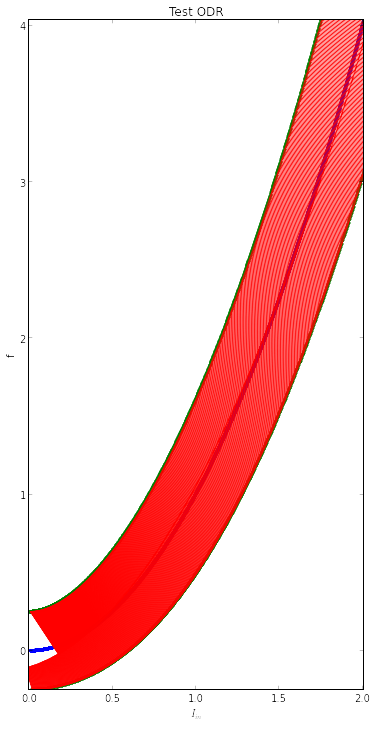

In [204]:
print 'alpha:\t\t', myfit.beta[0]
print 'beta:\t\t', myfit.beta[1]
print 'gamma:\t\t', myfit.beta[2]

# Plot the data
fig = figure(figsize(6,12))
plotData(Xs, Fs, lims=((0,max(Xs)),(0,max(Fs))), lStyle='', col='b', aLbl=(r'$x$',r'$f(x)$'))
plotData(skewXs, skewFs, lims=((min(skewXs),max(skewXs)),(min(skewFs),max(skewFs))),col='g',aLbl=(r'$x$',r'$f(x)$'))
plotData(thXs, thFs, lims=((min(thXs),max(thXs)),(min(thFs),max(thFs))), mStyle='', lStyle='--', col='b', aLbl=(r'$x$',r'$f(x)$'))

#print skewXs, '\n', myfit.xplus,'\n', skewFs, '\n', myfit.y
for i, curX in enumerate(skewXs):
    plotData([curX,myfit.xplus[i]],[skewFs[i],myfit.y[i]],
             mStyle='', lStyle='-',col='r')
outFs = sq(myfit.beta,thXs)
plotData(thXs, outFs, lims=((min(thXs),max(thXs)),(min(min(thFs),min(skewFs)),max(thFs))),mStyle='',lStyle='--',col='r',aLbl=(r'$I_{in}$',r'f'))

In [84]:
print "Delta:\t\t", myfit.delta
print "Eps:\t\t", myfit.eps
print "X+delta:\t:", myfit.xplus
print "Calc X+delta:\t", skewXs + myfit.delta

Delta:		[-0.04161348 -0.62227141  1.2455201  -0.81440442  1.05996081 -1.03266693
  0.84467514 -1.25905828  0.61985767]
Eps:		[-0.01583381  0.1827204  -0.2519948   0.1296709  -0.138101    0.11488227
 -0.08167745  0.10806584 -0.04773277]
X+delta:	: [ 0.06395933  1.82641189  2.2753776   2.66617626  3.07356689  3.45728256
  3.85239726  4.23482545  4.62482047]
Calc X+delta:	[ 0.06395933  1.82641189  2.2753776   2.66617626  3.07356689  3.45728256
  3.85239726  4.23482545  4.62482047]


In [85]:
print "Y:\t\t", myfit.y
print "Calc Y:\t\t", sq(myfit.beta, myfit.xplus), "\n"
print "Calc Y:\t\t", sq(myfit.beta,(skewXs+myfit.delta)), "\n"

Y:		[  1.43137978   2.11649263   3.99054083   6.18355477   9.02629799
  12.22346091  16.04235729  20.24763431  25.05177095]
Calc Y:		[  1.43137978   2.11649263   3.99054083   6.18355477   9.02629799
  12.22346091  16.04235729  20.24763431  25.05177095] 

Calc Y:		[  1.43137978   2.11649263   3.99054083   6.18355477   9.02629799
  12.22346091  16.04235729  20.24763431  25.05177095] 



In [116]:
print "Orthogonal Error Sq:\t", myfit.delta**2+myfit.eps**2
print "Orthogonal Error:\t", sqrt(myfit.delta**2+myfit.eps**2), "\n"

Orthogonal Error Sq:	[ 0.00198239  0.42060845  1.6148217   0.6800691   1.1425888   1.07959893
  0.7201473   1.59690598  0.38650194]
Orthogonal Error:	[ 0.04452406  0.64854333  1.27075635  0.82466302  1.06891946  1.0390375
  0.84861493  1.26368746  0.6216928 ] 



In [165]:
print "Res. Var:\t",myfit.res_var
print "Calc Res. Var:\t",sum(myfit.delta**2+myfit.eps**2)/(len(myfit.eps)-3)

Res. Var:	1.27387076523
Calc Res. Var:	1.27387076523


In [ ]:
rsd = sqrt(myfit.res_var)/sqrt(sum(myfit.y**2)/(len(myfit.y)-2))
print "Rel. Std. Dev:\t", rsd
print "Calc. Rel Error:\t", sqrt(myfit.sum_square/(len(myfit.delta)-2))/sqrt(sum(myfit.y**2)/(len(myfit.y)-2))
print ""

print "Sum[e^2]:\t", myfit.sum_square
print "Calc_Sum[e^2]:\t", sum(myfit.delta**2+myfit.eps**2)
print "Sum[delta^2]:\t\t", myfit.sum_square_delta
print "Calc_Sum[delta^2]:\t", sum(myfit.delta**2)
print "Sum[eps^2]:\t\t", myfit.sum_square_eps
print "Calc_Sum[eps^2]:\t", sum(myfit.eps**2)
print "Rel Error:\t",myfit.rel_error

# Test a simple model of $x^2$

This test will use a simpler $x^2$ equation to test the ODR model.  More specifically it will use the following equation to model any simple quadratic equation: $$ f(x)=\alpha x^2 $$

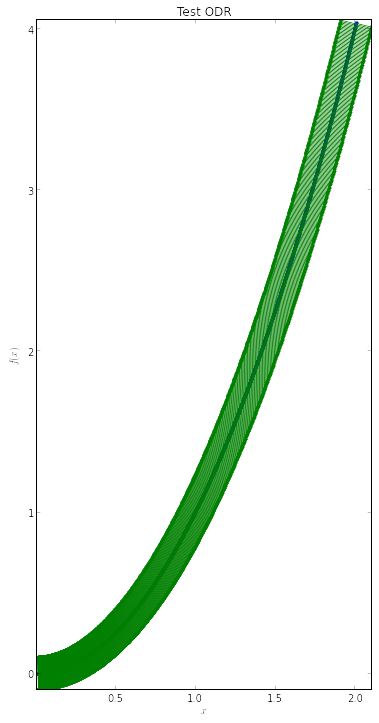

In [214]:
FsSimp = sqSimple(alpha,Xs)
MsSimp = dsqSimple(alpha, Xs)

invMsSimp = -(1/MsSimp)
BsSimp = bCalc(FsSimp, Xs, MsSimp)
invBsSimp = bCalc(FsSimp, Xs, invMsSimp)

# Setup data in order to plot a high-resolution theoretical curve
thXsSimp = arange(0,MaxX,0.001)
thFsSimp = sqSimple(alpha,thXsSimp)

# Skew the data
scaleSimp = 0.1     # Set this variable to scale the vector length
dxSimp = scaleSimp*cos(arctan(invMsSimp))
dySimp = scaleSimp*sin(arctan(invMsSimp))

skewXsSimp = Xs.copy()
skewXsSimp[0::2] -= dxSimp[0::2]
skewXsSimp[1::2] += dxSimp[1::2]
skewFsSimp = FsSimp.copy()
skewFsSimp[0::2] -= dySimp[0::2]
skewFsSimp[1::2] += dySimp[1::2]

# Plot the data
fig = figure(figsize(6,12))
plotData(Xs, FsSimp, lims=((0,max(Xs)),(0,max(FsSimp))), lStyle='', col='b', aLbl=(r'$x$',r'$f(x)$'))
for i, m in enumerate(MsSimp):
#    plotData(thXsSimp, simpLine(thXsSimp, m, BsSimp[i]), mStyle='', lStyle='-.')
#    plotData(thXsSimp, simpLine(thXsSimp, invMsSimp[i], invBsSimp[i]), mStyle='', lStyle='-.', col='g')
    plotData([Xs[i], skewXsSimp[i]],[FsSimp[i],skewFsSimp[i]], mStyle='', lStyle='-', col='g')
plotData(skewXsSimp, skewFsSimp, lims=((min(skewXsSimp),max(skewXsSimp)),(min(skewFsSimp),max(skewFsSimp))),col='g',aLbl=(r'$x$',r'$f(x)$'))
#plotData(thXsSimp, thFsSimp, lims=((min(thXsSimp),max(thXsSimp)),(min(thFsSimp),max(thFsSimp))), mStyle='', lStyle='--', col='b', aLbl=(r'$x$',r'$f(x)$'))

### Run the ODR algorithm

In [215]:
#mydata = Data(Xs,Fs)
mydataSimp = Data(skewXsSimp,skewFsSimp)
modelSimp = Model(sqSimple)
myodrSimp = ODR(
    mydataSimp, modelSimp,
    beta0=[alpha],
    sstol=1e-10, partol=1e-12, maxit=500, taufac=1)
myfitSimp = myodrSimp.run()

### Output the ODR Results

alpha:		0.999917481021


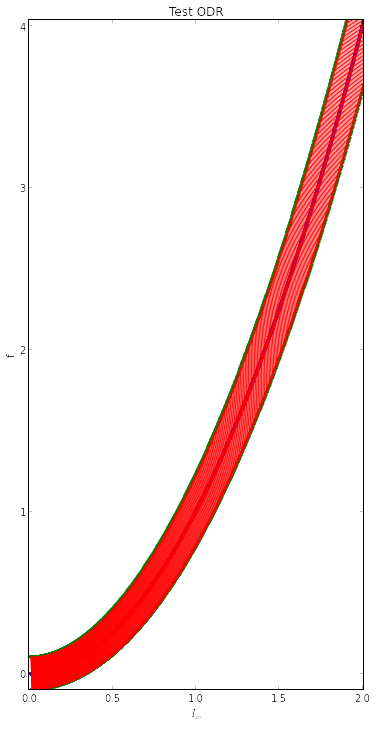

In [216]:
print 'alpha:\t\t', myfitSimp.beta[0]

# Plot the data
fig = figure(figsize(6,12))
plotData(Xs, FsSimp, lims=((0,max(Xs)),(0,max(FsSimp))), lStyle='', col='b', aLbl=(r'$x$',r'$f(x)$'))
plotData(skewXsSimp, skewFsSimp, lims=((min(skewXsSimp),max(skewXsSimp)),(0,max(skewFsSimp))),col='g',aLbl=(r'$x$',r'$f(x)$'))
plotData(thXsSimp, thFsSimp, lims=((min(thXsSimp),max(thXsSimp)),(min(thFsSimp),max(thFsSimp))), mStyle='', lStyle='--', col='b', aLbl=(r'$x$',r'$f(x)$'))

#print skewXs, '\n', myfitSimp.xplus,'\n', skewFs, '\n', myfitSimp.y
for i, curX in enumerate(skewXsSimp):
    plotData([curX,myfitSimp.xplus[i]],[skewFsSimp[i],myfitSimp.y[i]],
             mStyle='', lStyle='-',col='r')
outFsSimp = sqSimple(myfitSimp.beta,thXsSimp)
plotData(thXsSimp, outFsSimp, lims=((min(thXsSimp),max(thXsSimp)),(min(append(skewFsSimp,thFsSimp)),max(thFsSimp))),mStyle='',lStyle='--',col='r',aLbl=(r'$I_{in}$',r'f'))

In [174]:
print "Res. Var:\t",myfitSimp.res_var
print "Calc Res. Var:\t",sum(myfitSimp.delta**2+myfitSimp.eps**2)/(len(myfitSimp.eps)-1)

Res. Var:	1.00024393697
Calc Res. Var:	1.00024393697


# Scratch Pad

This section below here is for me to play around and see how things work and/or what things are without needing to document it in my code above

I'm playing around with what the "work" array is about.  It appears that it's an array of output values indexed by the dictionary "work_ind".  This array of output values can help debug more information if I am able to decode what all of the key values mean

In [ ]:
print len(myfit.work), myfit.work_ind
print myfit.stopreason
print myfit.work[6:12]
print myfit.work[myfit.work_ind['eps']:myfit.work_ind['xplus']]

In [ ]:
foo = array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0.45, 0.5, 0.6, 0.6, 0.3, 0.7, 0.8])
print foo

In [ ]:
print foo[foo<0.5]